In [1]:
from keras.applications import VGG16
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import RMSprop

/home/joshuah/venv3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/joshuah/venv3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/joshuah/venv3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Loading data into Colab

If you want to use Colab notebooks for your HW or projects, you'll inevitably need to get your datasets into the Colbab environment. There are many ways to do this (https://colab.research.google.com/notebooks/io.ipynb) but the easiest tends to be just loading your files into your Drive account. 

I've gathered a small dataset from Kaggle's Cats-vs-Dogs challenge and made the images available here if you're interested - https://s3.amazonaws.com/anly-590/cats_dogs_small/cats_dogs_small.zip


Then, I've uploaded these images directories into my Drive. By mounting my Drive volume, we can access folders and files located in Drive and pull them into a Colab notebook, exactly as if we were accessing local files on a local notebook.

In [2]:
from google.colab import drive

ImportError: No module named 'google.colab'

In [19]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


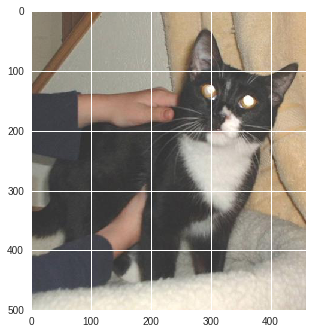

In [23]:
plt.imshow(load_img("/content/gdrive/My Drive/anly590-datasets/cats_dogs_small/test/cat/2000.jpg"))

In [56]:

path_train_data = "/content/gdrive/My Drive/anly590-datasets/cats_dogs_small/train/"
path_validation_data = "/content/gdrive/My Drive/anly590-datasets/cats_dogs_small/val"
path_test_data = "/content/gdrive/My Drive/anly590-datasets/cats_dogs_small/test"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path_train_data,
        classes = ['cat','dog'],
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
        path_validation_data,
        classes = ['cat','dog'],
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        path_test_data,
        classes = ['cat','dog'],
        target_size=(150,150),
        batch_size=32,
        class_mode='binary')

Found 2002 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.
Found 1007 images belonging to 2 classes.


### Transfer Learning with VGG backbone

In [ ]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [61]:
model.trainable_weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'block3_conv3

We'll use the VGG convolutional base, but it is important that we only train the weights on our Dense layers. That is, we want to keep the VGG weights fixed and not adjuste them during training. This is known as "freezing" the weights for transfer learning.


In [ ]:
conv_base.trainable = False

In [63]:
model.trainable_weights

[<tf.Variable 'dense_3/kernel:0' shape=(8192, 256) dtype=float32_ref>,
 <tf.Variable 'dense_3/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_4/kernel:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32_ref>]

Now we'll compile and train the model.

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-4),metrics=["acc"])

In [68]:
model.fit_generator(train_generator, steps_per_epoch=100, epochs=5, validation_data=validation_generator,validation_steps=25)

Epoch 1/5
  3/100 [..............................] - ETA: 17:32 - loss: 0.9418 - acc: 0.5289

KeyboardInterrupt: ignored

# Exercise - CIFAR **10**

The CIFAR-10 dataset is an image classification dataset with small images over 10 categories such as truck, bird, airplane, and several more. The dataset is available in Keras and comes with over 50 thousand images. For this exercise, we're going to use only a small sub-sample of the images (one thousand images) to explore the benefits of transfer learning.

0. Below, we load in the CIFAR-10 dataset and generate only a tiny subsample of the data that we will use for training.
1. Build and train a deep CNN for the subset of CIFAR-10 data. Evaluate your model using any metrics you prefer.
2. Use transfer learning to leverage an existing pre-trained convolutional backbone such as VGG (or any other). Note - when you load the backbone model, you'll like have to adjust the input_shape to match the CIFAR-10 images. 

In [24]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 15s 0us/step


In [ ]:
x_train = x_train[0:1000]
y_train = y_train[0:1000]

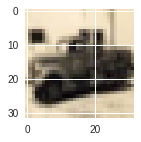

In [36]:
plt.figure(figsize = (2,2))
plt.imshow(x_train[319])